<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_PreProcessed_CNN5_A3_FineTuned1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import cv2
import keras
import os
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense
from keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.resnet50 import preprocess_input


In [9]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Preparation

In [10]:
 #Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/My Drive/Dataset/Dataset2/UTKDataset.zip"
output_directory = "/content/UTKDataset"
# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(output_directory)
    print('Done unzipping UTKDataset.zip')

Done unzipping UTKDataset.zip


In [11]:
import pandas as pd
train_df = pd.read_csv( "/content/UTKDataset/UTKDataset/train_labels.csv")
test_df = pd.read_csv("/content/UTKDataset/UTKDataset/test_labels.csv")


In [12]:
train_df.head()

,filepath,age
0,/content/UTKDataset/UTKDataset/train/85_1_0_20...,85
1,/content/UTKDataset/UTKDataset/train/5_0_2_201...,5
2,/content/UTKDataset/UTKDataset/train/63_0_0_20...,63
3,/content/UTKDataset/UTKDataset/train/13_0_0_20...,13
4,/content/UTKDataset/UTKDataset/train/32_1_0_20...,32


In [13]:
test_df.head()

,filepath,age
0,/content/UTKDataset/UTKDataset/test/47_0_0_201...,47
1,/content/UTKDataset/UTKDataset/test/65_0_0_201...,65
2,/content/UTKDataset/UTKDataset/test/35_1_0_201...,35
3,/content/UTKDataset/UTKDataset/test/50_0_0_201...,50
4,/content/UTKDataset/UTKDataset/test/49_0_0_201...,49


In [14]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]

In [15]:
def categorize_age(age):
    for range_name, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return range_name
    return None

In [16]:
train_df['target'] = train_df['age'].map(categorize_age)
test_df['target'] = test_df['age'].map(categorize_age)

In [17]:
train_df.head()

,filepath,age,target
0,/content/UTKDataset/UTKDataset/train/85_1_0_20...,85,6
1,/content/UTKDataset/UTKDataset/train/5_0_2_201...,5,1
2,/content/UTKDataset/UTKDataset/train/63_0_0_20...,63,5
3,/content/UTKDataset/UTKDataset/train/13_0_0_20...,13,2
4,/content/UTKDataset/UTKDataset/train/32_1_0_20...,32,4


In [18]:
test_df.head()

,filepath,age,target
0,/content/UTKDataset/UTKDataset/test/47_0_0_201...,47,5
1,/content/UTKDataset/UTKDataset/test/65_0_0_201...,65,5
2,/content/UTKDataset/UTKDataset/test/35_1_0_201...,35,4
3,/content/UTKDataset/UTKDataset/test/50_0_0_201...,50,5
4,/content/UTKDataset/UTKDataset/test/49_0_0_201...,49,5


In [19]:
train_df.shape

(7824, 3)

In [20]:
test_df.shape

(1956, 3)

In [21]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_filenames_list = list(train_df['filepath'])
train_labels_list = list(train_df['target'])

test_filenames_list = list(test_df['filepath'])
test_labels_list = list(test_df['target'])

In [22]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.
# Create tensors from the DataFrame
train_filenames_tensor = tf.convert_to_tensor(train_df['filepath'].values, dtype=tf.string)
train_labels_tensor = tf.convert_to_tensor(train_df['age'].values, dtype=tf.int32)  # Convert to int32

test_filenames_tensor = tf.convert_to_tensor(test_df['filepath'].values, dtype=tf.string)
test_labels_tensor = tf.convert_to_tensor(test_df['age'].values, dtype=tf.int32)  # Convert to int32


In [23]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=3)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [24]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
train_dataset = train_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_dataset = train_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(32)    # Same as batch_size hyperparameter in model.fit() below.

In [25]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = keras.layers.Input(shape=[224, 224, 3]) # input is 192x192 pixels RGB

y = keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = keras.layers.GlobalAveragePooling2D()(y)
y = keras.layers.Dense(len(age_ranges), activation='softmax')(y)

model = keras.Model(x, y)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_PreProcessed_CNN5_A3_FineTuned1.keras',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)

In [27]:
# Train your model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=60,batch_size=32, callbacks=[early_stopping,model_checkpoint])

Epoch 1/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.1314 - loss: 0.4515
Epoch 1: val_accuracy improved from -inf to 0.09969, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_PreProcessed_CNN5_A3_FineTuned1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 90s 244ms/step - accuracy: 0.1314 - loss: 0.4514 - val_accuracy: 0.0997 - val_loss: 0.4273
Epoch 2/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1181 - loss: 0.4123
Epoch 2: val_accuracy improved from 0.09969 to 0.10787, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_PreProcessed_CNN5_A3_FineTuned1.keras
245/245 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.1181 - loss: 0.4123 - val_accuracy: 0.1079 - val_loss: 0.4016
Epoch 3/60
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1139 - loss: 0.4075
Epoch 3: val_accuracy did not improve from 0.10787
245/245 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.1139 - loss: 0.4075 - val_accuracy: 0.1048 - val_loss: 0

In [28]:
# Save the training history
history_dict = history.history

# Plot the training and validation metrics
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

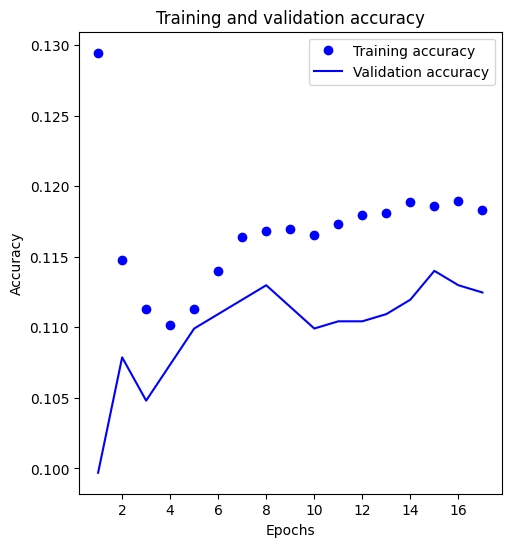

In [29]:
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

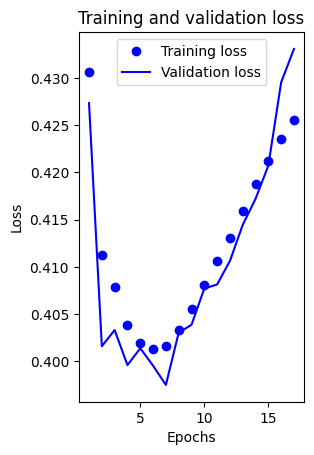

In [30]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [31]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/D1_PreProcessed_CNN5_A3_FineTuned1.keras')
# Evaluate the model
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(test_dataset, verbose=1)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.1093 - loss: 0.4211
Validation Loss: 0.42073723673820496
Validation Accuracy: 0.11400818079710007


In [32]:
representative_ages = [np.mean(rng) for rng in age_ranges]
representative_ages

[1.5, 6.0, 15.0, 24.0, 36.5, 55.5, 91.0]

In [33]:
# Convert predictions and true labels back to representative ages
y_pred = model.predict(test_dataset)
y_pred_ages = [representative_ages[np.argmax(pred)] for pred in y_pred]

# Since val_labels is one-hot encoded, convert it to a numpy array and then to representative ages
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)
y_true_ages = [representative_ages[np.argmax(true)] for true in val_labels_np]

# Calculate MAE
mae = np.mean(np.abs(np.array(y_true_ages) - np.array(y_pred_ages)))
print(f'Test MAE: {mae:.2f}')

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
Test MAE: 26.59


In [34]:
# Calculate MAE for each age range
age_range_mae = {}
for idx, age_range in enumerate(age_ranges):
    # Get the indices for the current age range
    range_indices = [i for i, age in enumerate(y_true_ages) if age_range[0] <= age <= age_range[1]]

    if range_indices:
        # Calculate MAE for the current age range
        y_true_range = np.array([y_true_ages[i] for i in range_indices])
        y_pred_range = np.array([y_pred_ages[i] for i in range_indices])

        mae = np.mean(np.abs(y_true_range - y_pred_range))
        age_range_mae[age_range] = mae

# Print MAE for each age range
for age_range, mae in age_range_mae.items():
    print(f"Age Range {age_range}: MAE = {mae:.2f}")

Age Range (1, 2): MAE = 30.98
Age Range (3, 9): MAE = 1.71
Age Range (10, 20): MAE = 9.04
Age Range (21, 27): MAE = 18.96
Age Range (28, 45): MAE = 27.27
Age Range (46, 65): MAE = 34.69
Age Range (66, 116): MAE = 68.92


In [35]:
# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
# Note: val_labels_np should be a concatenation of one-hot encoded labels from val_dataset
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Optionally, print some of the predicted and true class labels to verify
print("Sample predicted classes:", predicted_classes[:10])
print("Sample true classes:", true_classes[:10])

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Sample predicted classes: [2 4 4 4 4 1 5 1 5 4]
Sample true classes: [0 0 0 0 0 1 0 5 0 0]


In [36]:
# Define age ranges
age_ranges = [(1, 2), (3, 9), (10, 20), (21, 27), (28, 45), (46, 65), (66, 116)]
age_labels = {i: f"{start}-{end}" for i, (start, end) in enumerate(age_ranges)}

# Initialize a count dictionary
age_range_counts = {label: 0 for label in age_labels.values()}

# Count the samples in each age range
for age in y_true_ages:  # Assuming true_classes contains the true labels for test data
    for i, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            range_label = age_labels[i]
            age_range_counts[range_label] += 1
            break

# Convert to DataFrame for better visualization
age_range_counts_df = pd.DataFrame(list(age_range_counts.items()), columns=['Age Range', 'Count'])

# Display the counts
print(age_range_counts_df)

  Age Range  Count
0       1-2   1470
1       3-9    215
2     10-20    102
3     21-27     59
4     28-45     52
5     46-65     40
6    66-116     18


In [37]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.11
Precision: 0.58
Recall: 0.11
F1-score: 0.07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [39]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-2: 0.00
Accuracy for age range 3-9: 0.96
Accuracy for age range 10-20: 0.03
Accuracy for age range 21-27: 0.00
Accuracy for age range 28-45: 0.04
Accuracy for age range 46-65: 0.17
Accuracy for age range 66-116: 0.00


In [40]:
# Example metrics calculation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-2       0.71      0.00      0.01      1470
         3-9       0.38      0.96      0.55       215
       10-20       0.01      0.03      0.01       102
       21-27       0.00      0.00      0.00        59
       28-45       0.00      0.04      0.00        52
       46-65       0.02      0.17      0.04        40
      66-116       0.00      0.00      0.00        18

    accuracy                           0.11      1956
   macro avg       0.16      0.17      0.09      1956
weighted avg       0.58      0.11      0.07      1956


Confusion Matrix:
[[  5 116 329   0 763 257   0]
 [  0 206   1   0   2   6   0]
 [  0  98   3   0   0   1   0]
 [  1  48   2   0   2   6   0]
 [  1  38   6   0   2   5   0]
 [  0  20   7   0   6   7   0]
 [  0  11   0   0   3   4   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
Normalized confusion matrix


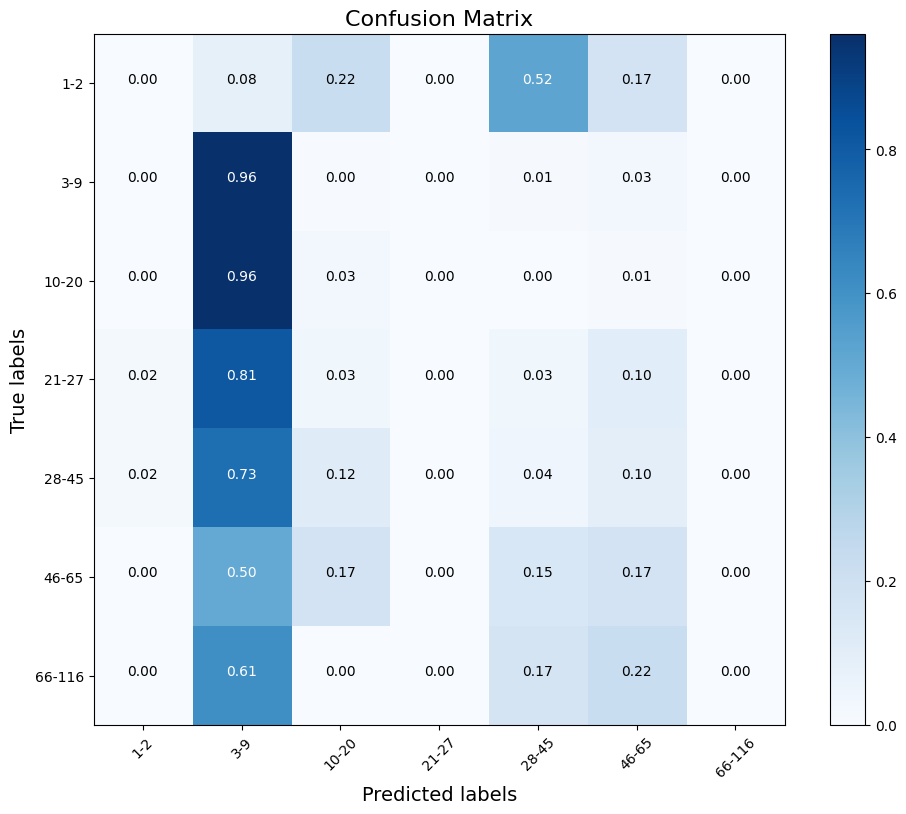

In [41]:
import itertools

# Define your function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

# Make predictions on the validation dataset
predictions = model.predict(test_dataset)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since val_labels is one-hot encoded, convert it to class labels
val_labels_np = np.concatenate([y for x, y in test_dataset], axis=0)  # Flatten the labels
true_classes = np.argmax(val_labels_np, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Age range labels
age_range_labels = [f'{start}-{end}' for start, end in age_ranges]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plot_confusion_matrix(conf_matrix, classes=age_range_labels,normalize=True, title='Confusion Matrix')
plt.show()